In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from skimage import data, color, feature
import skimage.data

from skimage.feature import hog
from skimage.color import rgb2grey


## HOG Features

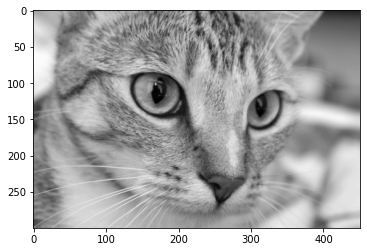

In [3]:
image = data.chelsea()
plt.imshow(image)

img_to_gray=color.rgb2gray(image)
plt.imshow(img_to_gray, cmap='gray')

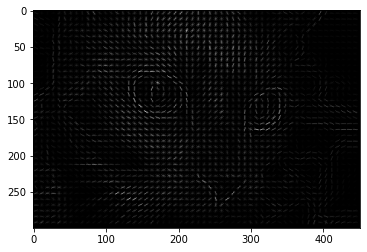

In [4]:
hog_vec, hog_vis = feature.hog(img_to_gray,visualize=True)
plt.imshow(hog_vis, cmap='gray')

In [5]:
hog_vec.shape

(153090,)

## Obtain a set of positive training samples

In [6]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

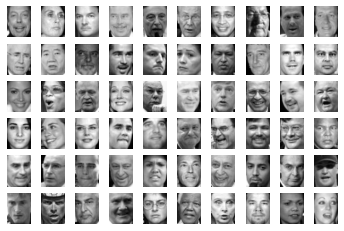

In [7]:
fig,ax = plt.subplots(6, 10)

for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[5 * i], cmap='gray')
    axi.axis('off')

## Obtained a set of negative training samples

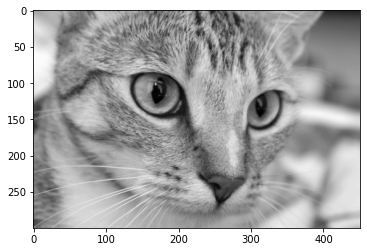

In [8]:
from skimage import data, transform
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

images = []
for name in imgs_to_use:
    img = getattr(data,name)()
    img = color.rgb2gray(img)
    images.append(img)

plt.imshow(images[7], cmap='gray')

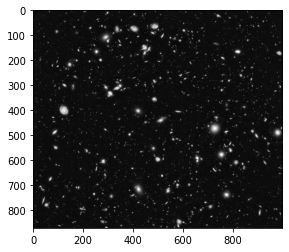

In [9]:
plt.imshow(images[9], cmap='gray')

In [10]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(image, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    patches = extractor.transform(image[np.newaxis])

    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])

    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

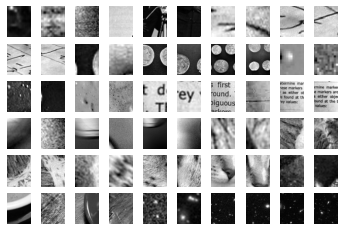

In [11]:
fig,ax = plt.subplots(6, 10)

for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [12]:
print(positive_patches.shape)
print(negative_patches.shape)

(13233, 62, 47)
(30000, 62, 47)


## Combine sets and extract HOG features

In [13]:
X_train=[]
y_train=[]

for img in positive_patches:
    p_img=feature.hog(img)
    X_train.append(p_img)
    y_train.append(1)

for img in negative_patches:
    n_img=feature.hog(img)
    X_train.append(n_img)
    y_train.append(0)

## Training a SVM

In [14]:
from sklearn.svm import LinearSVC

model=LinearSVC()
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [15]:
# Check how other algorithms work on this model

## Find faces in a new image

In [16]:
import skimage 
test_image=skimage.data.astronaut()
test_image = color.rgb2gray(test_image)


In [17]:
# Window size is (62,42) but our face is around 100,150

test_image = skimage.transform.rescale(test_image, 0.5) 

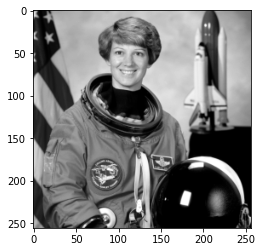

In [18]:
plt.imshow(test_image, cmap=plt.get_cmap('gray'))

In [19]:
def sliding_window(image, patch_size=positive_patches[0].shape,istep=2, jstep=2):
  #Creating patches from the image
    indices=[]
    patches=[]

    Ni,Nj=patch_size

    for i in range(0, image.shape[0]-Ni,istep):
        for j in range(0,image.shape[1]-Nj, jstep):
            patch=image[i: i+Ni, j:j+Nj]
            indices.append((i,j))
            patches.append(patch)

    return indices,patches

indices, patches = sliding_window(test_image)


In [20]:
len(patches)
print()

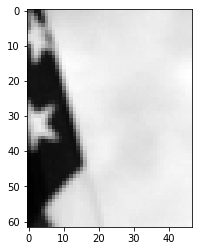

In [21]:
plt.imshow(patches[8],cmap='gray')


In [22]:
patch_hog=[]

for img in patches:
    f_hog =feature.hog(img)
    patch_hog.append(f_hog)

In [23]:
labels = model.predict(patch_hog)

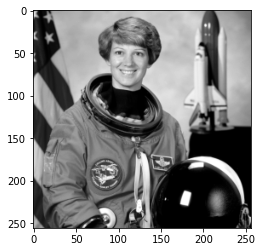

In [24]:
fig, ax = plt.subplots()
ax.imshow(test_image,cmap='gray')


Ni,Nj=positive_patches[0].shape

indices=np.array(indices)


for i,j in indices[labels==i]:
    ax.add_patch(plt.Rectangle((i,j)))